# Implementing Markov Chain Monte Carlo approach's Gibbs Sampling on generated data

In [16]:
# Import necessary libraries
import random
import time
import numpy as np
import math
from google.colab import drive
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

In [2]:
# Function to read sequences from input file given
# Input: sequence_count
# Output: Returns dna sequences

def read_sequences_from_input_file(sequence_count):

  # Reading sequences from the file
  dna_input_path = base_path + "differential_privacy_enforced_sequences_" + str(sequence_count) + ".txt"
  file_ptr = open(dna_input_path, 'r')
  seq_title_line, dna_sequences = True, []

  for each_seq in file_ptr:
    if seq_title_line:
      seq_title_line = False
    elif seq_title_line == False:
      dna_sequences.append(each_seq.strip('\n'))
      seq_title_line = True
  file_ptr.close()
  
  return dna_sequences


In [3]:
# Function to store results obtained to respective files
# Input: sequence_count, information_vector, profile_matrix
# Output: Does not return anything. Instead, it saves results to respective files

def store_results_to_respective_files(sequence_count, information_vector, profile_matrix):

  # Writing results to respective files
  # Result: predicted motif sites in dna sequences
  predicted_sites = information_vector[1][-1]
  output_sites_file = base_path + "predicted_sites_" + str(sequence_count) + ".txt"
  file_ptr = open(output_sites_file, 'w')
  for idx in range(0, len(predicted_sites)):
    file_ptr.write(str(predicted_sites[idx]) + '\n')
  file_ptr.close()

  # Result: Obtained motif
  output_motif_file = base_path + "predicted_motif_" + str(sequence_count) + ".txt"
  file_ptr = open(output_motif_file, 'w')
  file_ptr.write(motif_result + '\n')
  for row in range(0, len(profile_matrix)):
    for col in range(0, len(profile_matrix[row])):
      file_ptr.write(str(int(profile_matrix[row][col])) + '\t')
    file_ptr.write('\n')
  file_ptr.close()


In [4]:
# Function to compute the Position Weight Matrix (PWM) for N-1 sequences
# Input: dna_seqeunces, no_of_sequences, motif_length, sequence_length, motif_sites 
# Output: Returns pwm and ignored sequence

def compute_position_weight_matrix(dna_seqs, no_of_seqs, motif_len, seq_len, motif_sites):

  # To ignore a sequence, we generate a random number
  random.seed(time.time())
  ignored_seq = random.randrange(0, no_of_seqs)

  # Calculating the PWM
  # Rows: 4 representing A, G, T, C respectively
  # Columns: As many as the motif length
  pwm = np.zeros((4, motif_len))

  # Indexing the N-1 sequences
  idx = 0

  for seq_idx in range(0, no_of_seqs):

    # We ignore the previously selected random sequence
    if seq_idx == ignored_seq:
        continue

    else:
      for m_len in range(0, motif_len):
        value = dna_seqs[seq_idx][motif_sites[idx] + m_len]
        if value == nucleotides[0]:
          pwm[0][m_len] += 1
        elif value == nucleotides[1]:
          pwm[1][m_len] += 1
        elif value == nucleotides[2]:
          pwm[2][m_len] += 1
        elif value == nucleotides[3]:
          pwm[3][m_len] += 1
    idx += 1

  return pwm/(no_of_seqs - 1), ignored_seq


In [5]:
# Function to predict the motif_site in ignored sequence using the Position Weight Matrix
# Input: dna_seqeunces, ignored_seq, pwm, motif_length, sequence_length
# Output: Returns the predicted site

def predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_len, sequence_len):

  # Obtaining all possible prediction candidates of given motif length
  prediction_candidates = []
  for i in range(0, sequence_len - motif_len + 1):
    prediction_candidates.append((dna_sequences[ignored_seq])[i:i + motif_len])

  # Generating probabilities for all candidates to find the best possible prediction
  candidate_probabilities = []
  for pred_idx in range(0, len(prediction_candidates)):
    frequency, weighted_frequency = 1, 1

    for m_len in range(0, motif_len):
      value = prediction_candidates[pred_idx][m_len]
      if value == nucleotides[0]:
        frequency *= freq[0]
        weighted_frequency *= pwm[0][m_len]
      elif value == nucleotides[1]:
        frequency *= freq[1]
        weighted_frequency *= pwm[1][m_len]
      elif value == nucleotides[2]:
        frequency *= freq[2]
        weighted_frequency *= pwm[2][m_len]
      elif value == nucleotides[3]:
        frequency *= freq[3]
        weighted_frequency *= pwm[3][m_len]
    candidate_probabilities.append(weighted_frequency / frequency)

  # Normalizing the probabilities to obtain the predicted site
  normalized_probabilities = list(candidate_probabilities / sum(candidate_probabilities))
  predicted_site = normalized_probabilities.index(max(normalized_probabilities))
  return predicted_site


In [6]:
# Function to predict the motif_site in ignored sequence using the Position Weight Matrix
# Input: motif_sites, dna_seqeunces, motif_length, no_of_seqs, pwm
# Output: Returns information content and updated pwm

def compute_information_content(motif_sites, dna_seqs, motif_len, no_of_seqs, precomputed_pwm):
  
  # Calculating the PWM
  # Rows: 4 representing A, G, T, C respectively
  # Columns: As many as the motif length
  updated_pwm = np.zeros((4, motif_len))
  
  # Indexing the N-1 sequences
  idx = 0

  # Computing updated PWM
  for seq_idx in range(0, no_of_seqs):
    for m_len in range(0, motif_len):
      value = dna_seqs[seq_idx][motif_sites[idx] + m_len]
      if value == nucleotides[0]:
        updated_pwm[0][m_len] += 1
      elif value == nucleotides[1]:
        updated_pwm[1][m_len] += 1
      elif value == nucleotides[2]:
        updated_pwm[2][m_len] += 1
      elif value == nucleotides[3]:
        updated_pwm[3][m_len] += 1
    idx += 1
  updated_pwm = updated_pwm / no_of_seqs

  # Finding the information content based on the updated PWM
  info_content = 0
  for m_len in range(0, motif_len):
    for nuc_no in range(0, 4):
      if nuc_no == 0:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[0]
      elif nuc_no == 1:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[1]
      elif nuc_no == 2:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[2]
      elif nuc_no == 3:
        normalized_pwm = updated_pwm[nuc_no][m_len] / freq[3]
      if normalized_pwm == 0:
        continue
      info_content += updated_pwm[nuc_no][m_len] * math.log(normalized_pwm, 2)

  return info_content, updated_pwm


In [7]:
# Function to find max PWM and max info content
# Input: iterations, dna_sequences, motif_length, sequence_length, motif_sites
# Output: Returns information content, pwm and information vector

def compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites, acceptable_info_content = 1.7):

  # Declaring required variables
  added_prediction, max_info_content, iter_count = False, 0, 0
  information_vector = [['IC'], ['sites']]
  no_of_seqs = len(dna_sequences)
  
  print("Iterations to be completed: ", iterations)

  # Runs multiple iterations to obtain right values
  for iteration in range(0, iterations):
    
    # Tracking iterations
    iter_count += 1
    if iter_count % 100 == 0:
      print("Completed ", iter_count, " iterations")

    # Finding the Position Weight Matrix (PWM) for N-1 sequences
    pwm, ignored_seq = compute_position_weight_matrix(dna_sequences, no_of_seqs, motif_length, sequence_length, motif_sites)

    # Predicting the site in the ignored sequence using the PWM
    predicted_site_in_ignored_seq = predict_motif_site_in_ignored_seq(dna_sequences, ignored_seq, pwm, motif_length, sequence_length)

    # Adding the predicted site to the list if it is not yet added
    if added_prediction == False:
      motif_sites.insert(ignored_seq, predicted_site_in_ignored_seq)
      added_prediction = True
    else:
      motif_sites[ignored_seq] = predicted_site_in_ignored_seq
    motif_sites_temp = motif_sites[:]

    # Computing the information content of the prediction in the current iteration
    information_vector[1].append(motif_sites_temp)
    info_content, pwm = compute_information_content(motif_sites, dna_sequences, motif_length, no_of_seqs, pwm)
    information_vector[0].append(info_content)

    # Updating max. information content value
    if info_content > max_info_content:
      max_info_content = info_content
      max_pwm = pwm

    if info_content > (acceptable_info_content * motif_length):
      break

  # Updating info_content & pwm with the max. values respectively
  info_content = max_info_content
  pwm = max_pwm
  
  return info_content, max_pwm, information_vector


In [8]:
# Function to find motif from pwm using the sequences and motif length
# Input: pwm, no_of_seqs, motif_length
# Output: Returns motif result and profile matrix

def find_motif_from_pwm(pwm, no_of_seqs, motif_length):

  # Obtaining the motif from given dna sequences using Position Weight Matrix
  profile_matrix = np.transpose(pwm) * no_of_seqs
  motif_temp = []
  for m_len in range(0, motif_length):
    values_at_mlen = list(profile_matrix[m_len])
    max_value = max(values_at_mlen)

    # As two nucleotides may have equal probability of occurrence, we check if the max_value appears more than once
    max_value_indices = []
    for idx in range(0, len(values_at_mlen)):
      if values_at_mlen[idx] == max_value:
        max_value_indices.append(idx)
    
    if len(max_value_indices) > 1:
      motif_index = random.choice(max_value_indices)
    else:
      motif_index = values_at_mlen.index(max(values_at_mlen))
    
    motif_temp.append(nucleotides[motif_index])
  motif_result = ''.join(motif_temp)

  return motif_result, profile_matrix


In [9]:
# Function to find the percentage of sequences that have a minimum match of 50% of motif
# Input: all_dna_sequences, motif_results
# Output: Returns motif counts

def find_count_of_threshold_matched_sequences(all_dna_sequences, motif_results):
  
  # Finding the percentage match of motif in each input dna sequence
  motif_counts = {}
  print("Original motif counts:")

  for sequences in all_dna_sequences:
    motif_cnt = [0, 0, 0, 0, 0]
    data_size = len(sequences)

    for motif_idx in range(0, 5):
      motif = motif_results[motif_idx]
      for each_sequence in sequences:
        # seq_lenth = 300 and motif_length = 10
        # If atleast 5 characters are matched, it is good
        # So, percentage match should be 5/300 ~ 0.015
        if SequenceMatcher(None, motif, each_sequence).ratio() >= 0.01:
          motif_cnt[motif_idx] += 1
        
    print(motif_cnt, "for ", data_size, " dna sequences")
    motif_counts[data_size] = motif_cnt
    
  return motif_counts


In [10]:
# Function to find the normalized motif counts from actual counts
# Input: motif_counts
# Output: Returns normalized motif counts

def compute_normalized_motif_counts(motif_counts):

  # To plot the motif counts along the same scale, we normalize the counts
  normalized_motif_counts = {}
  print("\n\nNormalized motif counts:")

  for key in motif_counts:
    normalized_list = []
    for each_val in motif_counts[key]:
      normalized_list.append(each_val / key)
    normalized_motif_counts[key] = normalized_list
    print(normalized_motif_counts[key])

  return normalized_motif_counts


In [17]:
# Function to plot the motif match observations made
# Input: motif_results, normalized_motif_counts
# Output: Displays different bar graphs for various input sizes

def plot_motif_match_observations(motif_results, normalized_motif_counts):
  
  # Plotting normalized motif counts across the dna sequences considered
  colors = ['green', 'orange', 'olive', 'purple', 'maroon']
  idx = 0

  for key in normalized_motif_counts:
    x_axis = motif_results
    y_axis = normalized_motif_counts[key]
    
    bar_chart = plt.figure(figsize = (8, 5))
    plt.bar(x_axis, y_axis, color = colors[idx])
    plt.yticks(np.arange(0, 0.10, 0.02))
    plt.xlabel("Motifs found")
    plt.ylabel("Dna sequences which matched atleast 50% of motif_length")
    plt.title("Plot for " + str(key) + " sequences")
    
    idx += 1
    plt.show()


In [12]:
# Establish connection to use Google drive
drive.mount("/content/drive")
base_path = "drive/MyDrive/DNA-Dataset/Data/"


Mounted at /content/drive


In [13]:
# Define required variables
nucleotides = ['A','G','T','C']
freq = [0.25, 0.25, 0.25, 0.25]
sequence_length = 300   # Fixed: As the DNA contains 150 base pairs in general
motif_length = 10   # Motifs are generally 5-20 pairs long
sequence_counts = [1000, 5000, 10000, 50000, 100000]


In [14]:
# Executing Gibbs algorithm and store motif results obtained
motif_results, profile_matrices, all_dna_sequences = [], [], []
idx = 0

for sequence_count in sequence_counts:

  # Read DNA data from input files
  dna_sequences = read_sequences_from_input_file(sequence_count)
  all_dna_sequences.append(dna_sequences)
  
  no_of_seqs = len(dna_sequences)
  print("\n\n**********************")
  print("No. of DNA sequences: ", no_of_seqs)

  # As in Gibbs sampling, we select random starting points and 
  # generate motif site for all the remaining sequences
  motif_sites = []
  for i in range(0, no_of_seqs-1):
    random_start_site = random.randrange(0, sequence_length - motif_length)
    motif_sites.append(random_start_site)

  # Implementing Gibbs algorithm with several iterations
  iterations =  int(sequence_count / 10)
  info_content, pwm, information_vector = compute_max_pwm_and_ic(iterations, dna_sequences, motif_length, sequence_length, motif_sites)
  motif_result, profile_matrix = find_motif_from_pwm(pwm, no_of_seqs, motif_length)
  motif_results.append(motif_result)
  profile_matrices.append(profile_matrix)
  store_results_to_respective_files(sequence_count, information_vector, profile_matrix)

  # Analyzing the results obtained
  print("Motif discovered: ", motif_results[idx], "\n")
  idx += 1




**********************
No. of DNA sequences:  1000
Iterations to be completed:  100
Completed  100  iterations
Motif discovered:  ACCCGCAATT 



**********************
No. of DNA sequences:  5000
Iterations to be completed:  500
Completed  100  iterations
Completed  200  iterations
Completed  300  iterations
Completed  400  iterations
Completed  500  iterations
Motif discovered:  TGCTTGAATG 



**********************
No. of DNA sequences:  10000
Iterations to be completed:  1000
Completed  100  iterations
Completed  200  iterations
Completed  300  iterations
Completed  400  iterations
Completed  500  iterations
Completed  600  iterations
Completed  700  iterations
Completed  800  iterations
Completed  900  iterations
Completed  1000  iterations
Motif discovered:  GGGAATATGC 



**********************
No. of DNA sequences:  50000
Iterations to be completed:  5000
Completed  100  iterations
Completed  200  iterations
Completed  300  iterations
Completed  400  iterations
Completed  500 

In [18]:
# Finding the percentage match between motif and DNA sequences
motif_counts = find_count_of_threshold_matched_sequences(all_dna_sequences, motif_results)
normalized_motif_counts = compute_normalized_motif_counts(motif_counts)


Original motif counts:
[59, 56, 71, 62, 72] for  1000  dna sequences
[305, 297, 290, 318, 312] for  5000  dna sequences
[610, 595, 619, 634, 602] for  10000  dna sequences
[3175, 3154, 3120, 3092, 3149] for  50000  dna sequences
[6215, 6338, 6319, 6135, 6179] for  100000  dna sequences


Normalized motif counts:
[0.059, 0.056, 0.071, 0.062, 0.072]
[0.061, 0.0594, 0.058, 0.0636, 0.0624]
[0.061, 0.0595, 0.0619, 0.0634, 0.0602]
[0.0635, 0.06308, 0.0624, 0.06184, 0.06298]
[0.06215, 0.06338, 0.06319, 0.06135, 0.06179]


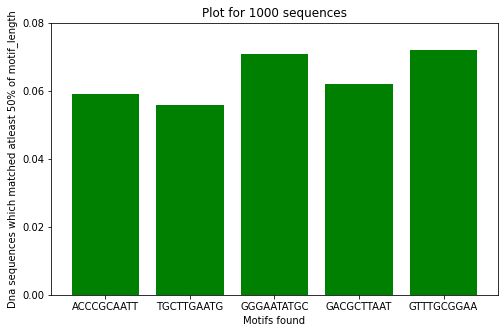

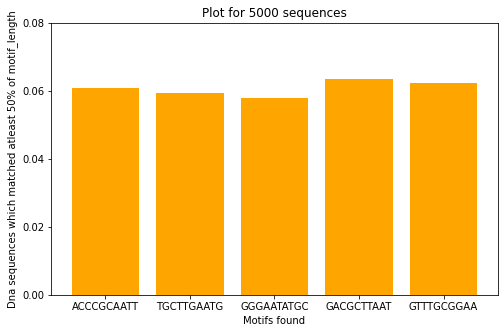

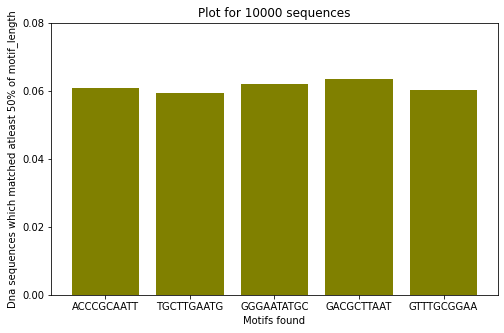

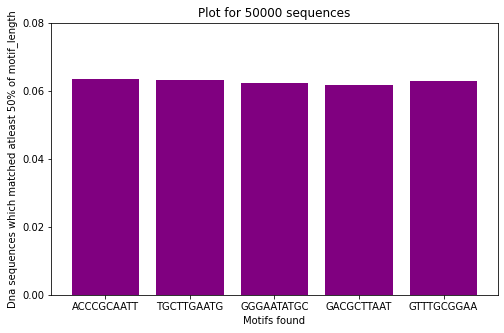

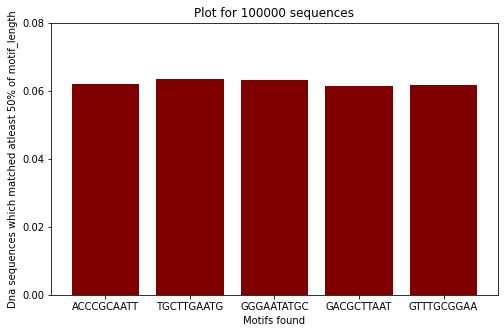

In [19]:
# Visualization
plot_motif_match_observations(motif_results, normalized_motif_counts)
